# Classification Performance in Parkinson's Disease Case and Controls

## Introduction

This notebook will assess several different contemporary ML model to assess classification on predicting cases and controls between PD user and non-PD users. To ensure the most reliable classification performance, we have ensured that 
the data has been randomized properly (matched). 

Classification model will be assessed using several basic classification models like LogReg, RandomForest, Gradient Boosting (Sklearn), XGBoost. To address model reliability for future project, learning curve will be assessed to ernsure that model does not overfit. 


<b> Classification Model Steps: </b>

    1. Remove columns with more than 20% null entry
    
    2. Split data into training - holdout set (75-25)% ratio
    
    3. Impute Data by Median

    4. Recursive Feature Elimination to reduce overfitting 

    5. Grid Search the model hyperparameter with K-fold cross validation 
       to optimize desired prediction metrics (roc-auc)
    
    6. Assess best model on holdout set

    7. Assess Model Performance

    8. Assess Feature Importances 

    9. Persist Best Model 

## Library Imports

In [1]:
# library and module imports for data retrieval and munging
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# some ML (scikit & xgboost) library imports for modelling
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import (train_test_split, learning_curve, GridSearchCV, cross_val_score, validation_curve)
import sklearn.metrics as metrics
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, SGDClassifier)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

  warnings.warn(msg, category=DeprecationWarning)



## Retrieve Data

#### Global Variables

In [2]:
WALKING_GROUPED_FEATURES    = "syn21678699"
MATCHED_DEMOGRAPHICS        = "syn21614563"
ALL_DEMOGRAPHICS            = "syn21602828"
PREVIOUS_ASSAY_DEMOGRAPHICS = "syn8381056"

syn = sc.login()

Welcome, aryton tediarjo!




UPGRADE AVAILABLE

A more recent version of the Synapse Client (2.0.0) is available. Your version (1.9.3) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 2.0.0 release notes

https://python-docs.synapse.org/build/html/news.html

INFO:synapseclient_default:Welcome, aryton tediarjo!



### Helper Functions

#### a. Model Fitting Function

In [35]:
### helper functions ###
### functions used to reduce feature spaces and model fitting/training ###

def reduce_feature_rfecv(X, y, 
                 estimator, 
                 score_func):
    """
    function to reduce features by
    recursively eliminating and adding
    features and optimize based on the
    scoring metrics provided
    
    Args: X: independent variables 
          y: dependent variables
          score_func: metrics to optimze
    returns reduced dataframe
    """
    selector = RFECV(estimator, step=1, 
                     cv=10, 
                     scoring = score_func, 
                     min_features_to_select = 20,
                     n_jobs = -1)
    selector = selector.fit(X, y)
    return pd.DataFrame(data = selector.transform(X), 
             columns = X.columns[selector.support_])


def logreg_wrapper(X, y):
    """
    wrapper for logistic regression hyperparameter
    """
    model = LogisticRegression(random_state = 100)
    X = reduce_feature_rfecv(X, y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('classifier', model)
        ])
    param = [{'classifier__penalty': ['l1'],
             'classifier__C':[0.1, 0.3, 0.5],
             'classifier__solver':['liblinear'],
             'classifier__max_iter': [100, 200, 300],
             'classifier__multi_class': ['ovr']}]
    CV = GridSearchCV(estimator = pipe, 
                      param_grid = param , 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}


def xgb_wrapper(X, y):
    """
    wrapper for logistic regression hyperparameter
    """
    model = XGBClassifier(random_state = 100)
    X = reduce_feature_rfecv(X,y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('classifier', model)
        ])
    param = {
        "classifier__learning_rate" : [0.1, 0.2, 0.3],
        "classifier__n_estimators"  : [100, 200],
        'classifier__max_depth'     : [3, 5, 7, 9],
        "classifier__subsample"     : [0.9, 1],
        "classifier__reg_alpha"     : [0.05, 0.1]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param, 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}
    

def gradientboost_wrapper(X, y):
    """
    wrapper for gradient boosting hyperparameter
    """
    model = GradientBoostingClassifier(random_state = 100)
    X = reduce_feature_rfecv(X,y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('classifier', model)
        ])
    param = {
        'classifier__max_depth'     : [3, 5, 7, 9],
        'classifier__learning_rate' : [0.1, 0.2, 0.3],
        "classifier__n_estimators"  : [100, 200],
        "classifier__subsample"     : [0.9, 1]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}


def randomforest_wrapper(X, y):
    """
    wrapper for random forest hyperparameter
    """
    model = RandomForestClassifier(random_state = 100)
    X = reduce_feature_rfecv(X,y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('classifier', model)
        ])
    param = {
        'classifier__n_estimators': [2000, 3000, 4000]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param, 
                      scoring= "roc_auc", 
                      n_jobs = -1, cv = 10, 
                      verbose = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}

#### b. Model Results & Visualization Function

In [4]:
### function to showcase results and metrics of predictive model ###
def get_results_dataframe(X_train, y_train, 
                          X_test, y_test, 
                          *fitted_models):
    data_dict = {}
    data_dict["model"] = []
    data_dict["parameter"] = []
    data_dict["roc-auc-cv"] = []
    data_dict["roc-auc-test"] = []
    for fitted_model in fitted_models:
        if isinstance(fitted_model, dict):
            model = fitted_model["model"]
            features = fitted_model["features"]
        else:
            model    = fitted_model
            features = X_test.columns 
        try:
            data_dict["model"].append(type(model.best_estimator_["classifier"]).__name__)
            data_dict["parameter"].append(model.best_params_)
            data_dict["roc-auc-cv"].append(model.best_score_)
        except:
            data_dict["model"].append(type(model).__name__)
            data_dict["parameter"].append(np.NaN)
            data_dict["roc-auc-cv"].append(np.mean(cross_val_score(model, X_train, 
                                                    y_train, scoring = "roc_auc")))
        y_pred = (model.predict_proba(X_test[features])[:,1])
        data_dict["roc-auc-test"].append(metrics.roc_auc_score(y_test, y_pred))
    data = pd.DataFrame(data_dict)
    return data


def visualize_feature_importances(X, *fitted_models):
    for fitted_model in fitted_models:
        try:
            features = fitted_model.best_estimator_["classifier"].feature_importances_
        except:
            features = fitted_model.best_estimator_["classifier"].coef_[0]

        series = np.abs(pd.Series(data = features, 
                            index = X.columns))\
                            .sort_values(ascending = True).tail(5)
        plt.figure(figsize = (8,5))
        plt.title("Feature Importances based base on %s"%type(fitted_model.best_estimator_["classifier"]).__name__)
        series.plot(kind = "barh")
        plt.show()
        

def plot_roc_auc_curve(X_test, y_test, *fitted_models):
    for fitted_model in fitted_models:
        model_name = type(fitted_model.best_estimator_["classifier"]).__name__
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        y_pred = fitted_model.predict_proba(X_test)
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[1], tpr[1], linestyle='-', 
                 label='%s ROC curve (area = %0.2f)' % 
                 (model_name, roc_auc[1]))
    
    

def plot_learning_curves(X_train, y_train, *fitted_models):
    for fitted_model in fitted_models:
        try:
            estimator = fitted_model.best_estimator_
            model_name = type(fitted_model.best_estimator_["classifier"]).__name__
        except:
            estimator = fitted_model
            model_name = type(fitted_model).__name__
        train_sizes, train_scores, valid_scores = learning_curve(estimator, 
                                                                X_train, y_train, 
                                                                scoring = "roc_auc", 
                                                                cv = 10, random_state = 100, 
                                                                train_sizes = np.linspace(0.1, 1, 10))
        pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1), 
                             "valid_scores": np.mean(valid_scores, axis = 1)}, 
                     index = train_sizes)\
                    .plot(figsize = (8,5), linestyle='-', marker = 'o')
        plt.ylabel("roc-auc")
        plt.title("%s Learning Curve"%model_name)
        plt.xlabel("Training Size")
        plt.show()
        

def plot_rfecv_performance(X_train, y_train, *fitted_models):
    plt.figure(figsize = (12,8))
    for fitted_model in fitted_models:
        selector = RFECV(fitted_model, 
                         step=1, 
                         cv=10, 
                         scoring = "roc_auc", 
                         n_jobs = -1)
        selector = selector.fit(X_train_impute, y_train)
        # Plot number of features VS. cross-validation scores
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation AUC-ROC score")
        plt.plot(range(1, len(selector.grid_scores_) + 1), 
                 selector.grid_scores_, 
                 label = type(fitted_model).__name__)
    plt.title("AUC-ROC Score Based on RFECV (10-fold)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    

    
def best_model_pipeline(test_set,
                        model_dict, 
                        imputer, feat_cols):
    ## impute data
    test_set = pd.DataFrame(imputer.fit_transform(test_set[feat_cols]), columns = feat_cols)
    result = model_dict.predict_proba(test_set)
    return result

#### Preliminary Cleanups
This is a preliminary cleanup on data, essentially changing column names and choosing columns that is required

In [26]:
#### get data ####
data = query.get_file_entity(syn, WALKING_GROUPED_FEATURES)
demographic = query.get_file_entity(syn, MATCHED_DEMOGRAPHICS).reset_index()


### filter unused columns ###
data = data[[feat for feat in data.columns 
            if ("window" not in feat) 
            and ("steps" not in feat) 
            and ("avg_number_of_strides" not in feat) 
            and ("amax" not in feat)
            and ("x_speed_of_gait" not in feat)
            and ("y_speed_of_gait" not in feat)
            and ("z_speed_of_gait" not in feat)]]


#### filter datasets ####
data = data[(data["test_type"] == "walking") & 
            (data["age"] > 0) & 
            (data["table_version"] != "MPOWER_PASSIVE") &
            (data["class"] != "MS")]

#### merge inner ####
data = pd.merge(
    demographic[["healthCode"]], data, on = "healthCode", how = "inner")

healthCode_list = data.healthCode
data = data.set_index("healthCode")



#### clean sparse feature ####
data = data[data.columns[data.isnull().mean() < 0.2]]


#### cols of choice ####
metadata_cols = ["test_type", "phoneInfo", "age", 
                 "gender", "table_version", 
                 "nrecords", "class"]
feat_cols = [feat for feat in data.columns if (feat not in metadata_cols)]

### 1. Imputation by Median

In [27]:
### map target variable ###
train = data[feat_cols]
target = data["class"].map({"PD":1, "control":0})

### split train test split ###
X_train, X_test, y_train, y_test = train_test_split(
    train, target,                                          
    test_size = 0.25,                                
    random_state = 100)

### imputer object ###
imputer = SimpleImputer(
    missing_values = np.nan,
    strategy = "median")\
    .fit(X_train)

### impute base on training sets ###
X_train_impute = pd.DataFrame(
    imputer.fit_transform(X_train), 
    columns = X_train.columns)

### impute fit on training predict on test ###
X_test_impute = pd.DataFrame(
    imputer.fit_transform(X_test), 
    columns = X_train.columns)

### 2. Assessing Initial Model Performance

Before we do any optimization on any of the ML model, we would like to have a baseline model based on the features that we currently have. Thus, we will test the baseline model by simply fit/predict on the training and test sets of our feature data, see what the initial performances <b> (roc-auc, f1-score, log-loss) </b> look like, and try to iterate/improve the baseline model. We will also be assessing the learning curve of our initial model and see whether the initial model can pick up some signals from the feature data. 

#### a. Initial Model Fitting

In [28]:
init_lr_model = LogisticRegression(
                random_state = 100)\
                .fit(X_train_impute, y_train)

init_rf_model = RandomForestClassifier(
                random_state = 100, 
                n_estimators = 100,
                bootstrap = True)\
                .fit(X_train_impute, y_train)

init_gb_model = GradientBoostingClassifier(
                random_state = 100, 
                n_estimators = 100)\
                .fit(X_train_impute, 
                     y_train)

init_xgb_model = XGBClassifier(
                random_state = 100, 
                n_estimators = 100)\
                .fit(X_train_impute, 
                     y_train)

#### b. Initial Model Metrics Performance

In [29]:
get_results_dataframe(
    X_train_impute, y_train,
    X_test_impute, y_test, 
    init_lr_model, init_rf_model, 
    init_xgb_model, init_gb_model)

,model,parameter,roc-auc-cv,roc-auc-test
0,LogisticRegression,NaN,0.703088,0.614726
1,RandomForestClassifier,NaN,0.650009,0.578291
2,XGBClassifier,NaN,0.659968,0.550989
3,GradientBoostingClassifier,NaN,0.651860,0.514650


#### c. Visualizing Feature Elimination

An approach of feature elimination can be done recursively, by adding and eliminating feature combinations repeatedly. This process is more effective than manually eliminating the features but it will be a time-consuming process as the data scales up. However, as we have large number of features but not as much samples on the dataset, this feature will be advantageous as we will not require that much time in repeatedly fitting the model with different subset of features. 

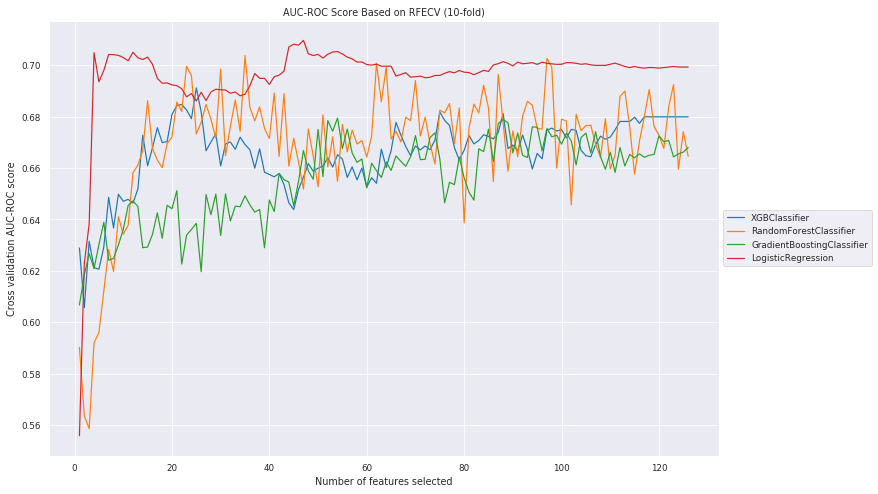

In [30]:
plot_rfecv_performance(
    X_train_impute, 
    y_train, 
    init_xgb_model,
    init_rf_model,
    init_gb_model,
    init_lr_model)

- Based on feature reduction process, we can see that logistic regression is able to reach optimality in a very around 40ish features, which means that there are a lot of noises in our data, which make sense due to how we collected all sensor data in all coordinates, which might be the cause of decrease in signal-to-noise ratio
- This is also noticable when plotting the ensemble models, we can see that they are reaching optimality on around 20 features (random forest and XGB), adding more features in these 2 ensemble models, does not actually increase performance. 
- Thus an approach would be to reduce the feature space, and see whether we can actually make the model less overfitted

## 3. Optimizing ML Model Performance

#### a. Slightly Optimization Approach 

As we can see from previous results, despite a decent result in our cross-validation set, we can see that the model is overfitted due to how it performs poorly on our test set. Therefore, we would want to generalize the model better by adding constraints of lower feature spaces, lower tree depth, and subsampling of data to make our model generalizes prediction better. Optimization will be done on 10-fold stratified K-cross validation, where we will assess the best mean scores of all folds collectively. <b> *This is a proof of concept of using scikit-learn pipeline class* </b>

<b> * 10-fold CV hyperparameter optimization process will be run on an 16-core AWS instance, so it might be computationally expensive if used on a local computer </b>

In [36]:
 ## models ##
cv_lr_model = logreg_wrapper(X_train_impute, y_train)
cv_rf_model = randomforest_wrapper(X_train_impute, y_train)
cv_gb_model = gradientboost_wrapper(X_train_impute, y_train)
cv_xgb_model = xgb_wrapper(X_train_impute, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.9s finished


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.4s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   27.1s finished


Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   17.9s finished


#### b. Prediction Results

In [37]:
results = get_results_dataframe(X_train, y_train,
                      X_test_impute, 
                      y_test, 
                      cv_gb_model,
                      cv_rf_model,
                      cv_lr_model,
                      cv_xgb_model)

In [38]:
results

,model,parameter,roc-auc-cv,roc-auc-test
0,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.747136,0.559741
1,RandomForestClassifier,{'classifier__n_estimators': 3000},0.688735,0.589992
2,LogisticRegression,"{'classifier__C': 0.5, 'classifier__max_iter':...",0.709952,0.625000
3,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.755789,0.549848


- The optimization shows that we could actually increase the CV scores, however, there is only slight improvement on the roc-auc test, this makes sense due to the instability of our features as feature engineering processes has not been done, which can cause biases in the test sets
- However, we know that if we use large number of estimators, we can actually fit a classifier to pick up some of the signals, which is what we would like to know in initial stages of classification pipeline
- For now, logistic regression might be the best classifier for walking data, as both the CV scores and test scores outperforms the older model which scores around (.62 AUC on an unknown test set) 

#### c. Model Boxplot Accross Folds

On assessing which model is the most reliable, we would like to test its performance stability based on the cross validation performance best parameter in terms of AUC. 

In [152]:
model_dict = {}
for cv_model in [cv_gb_model, cv_xgb_model, cv_rf_model, cv_lr_model]:
    cv_model = cv_model["model"]
    cv_model_name = type(cv_model.best_estimator_["classifier"]).__name__
    best_index = cv_model.best_index_
    model_dict[cv_model_name] = []
    for key in cv_model.cv_results_.keys():
        if ("split" in key) and ("test_score" in key):
            val = cv_model.cv_results_[key][best_index]
            model_dict[cv_model_name].append(val)

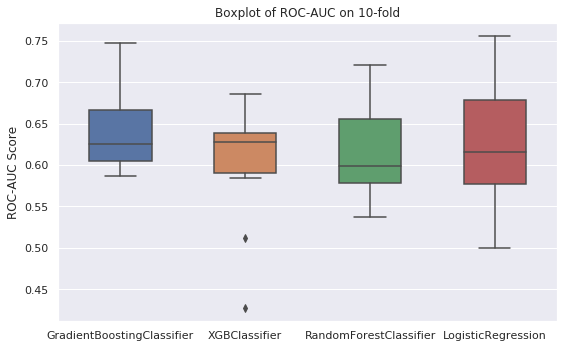

In [153]:
model_performance_data = pd.DataFrame(model_dict)

plt.figure(figsize = (8, 5))
sns.boxplot(data = model_performance_data, 
            width = 0.5)
plt.title("Boxplot of ROC-AUC on 10-fold")
plt.ylabel("ROC-AUC Score")
plt.tight_layout()
plt.show()

#### d. Feature Importances

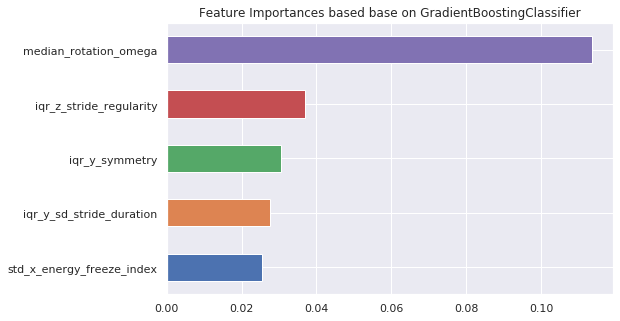

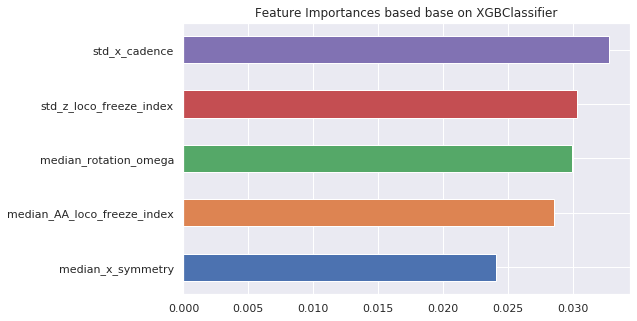

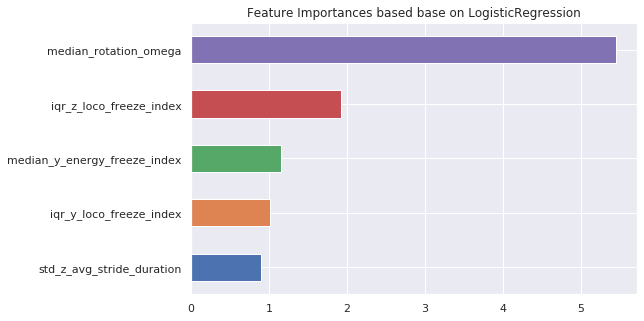

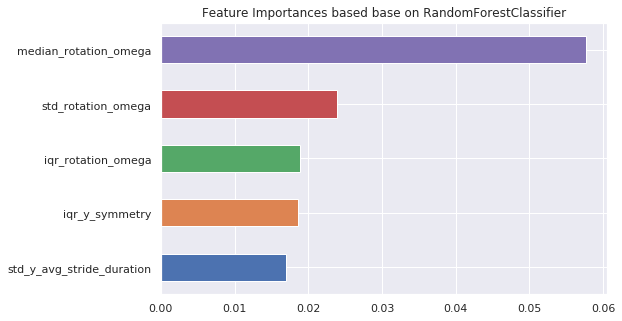

In [154]:
for fitted_model in [cv_gb_model, cv_xgb_model, cv_lr_model, cv_rf_model]:
    visualize_feature_importances(X_train_impute[fitted_model["features"]], 
                                  fitted_model["model"])

Based on the models fitted by cross validation, we can see that median of rotation speed is a prominent feature in classifying PD case vs controls. This is consistent to which in real life where PD has a hard time turning/rotating whenever they are walking. However, as we are using 10-fold cross validation, the strongest feature might be slightly overfitted as we fit the training data several times when assessing different folds. The way each model assessed feature importances is also different as how random forest is using stride durations as one of its strongest features, and does not use freeze index as one of its predictive features, unlike other features. 

#### e. ROC-AUC Curve

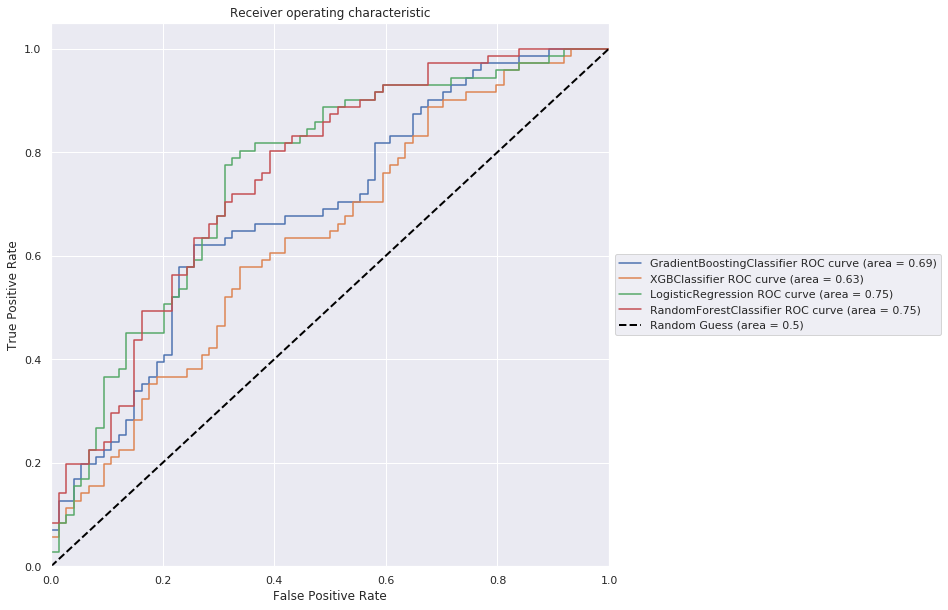

In [155]:
plt.figure(figsize = (10,10))


for fitted_model in [cv_gb_model, cv_xgb_model, cv_lr_model, cv_rf_model]:
    plot_roc_auc_curve(X_test_impute[fitted_model["features"]], 
                       y_test, 
                       fitted_model["model"])

plt.plot([0, 1], [0, 1], color='black', 
             lw=2, linestyle='--', 
             label = "Random Guess (area = 0.5)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Test on Passive Records 

#### Preliminary cleanups

In [156]:
### Testing on Passive Data

#### get data ####
data = query.get_file_entity(syn, WALKING_GROUPED_FEATURES)
demographic = query.get_file_entity(syn, ALL_DEMOGRAPHICS).reset_index()


### filter unused columns ###
data = data[[feat for feat in data.columns 
            if ("window" not in feat) 
            and ("steps" not in feat) 
            and ("avg_number_of_strides" not in feat) 
            and ("amax" not in feat)
            and ("x_speed_of_gait" not in feat)
            and ("y_speed_of_gait" not in feat)
            and ("z_speed_of_gait" not in feat)]]

#### filter datasets ####
data = data[(data["test_type"] == "walking") & 
            (data["age"] > 0) & 
            (data["table_version"] == "MPOWER_PASSIVE") &
            (data["class"] != "MS")]

data_PD = data[data["class"] == "PD"].sample(n = 15, random_state = 100)
data_nonPD = data[data["class"] == "control"].sample(n = 11, random_state = 100)

data = pd.concat([data_PD, data_nonPD], ignore_index = True)
passive_set = data

In [161]:
pred_result = best_model_pipeline(passive_set, 
                                  cv_rf_model["model"], 
                                  imputer, 
                                  cv_rf_model["features"])
true_result = passive_set["class"].map({"PD":1, "control":0})
data["probability"] = pred_result[:,1]

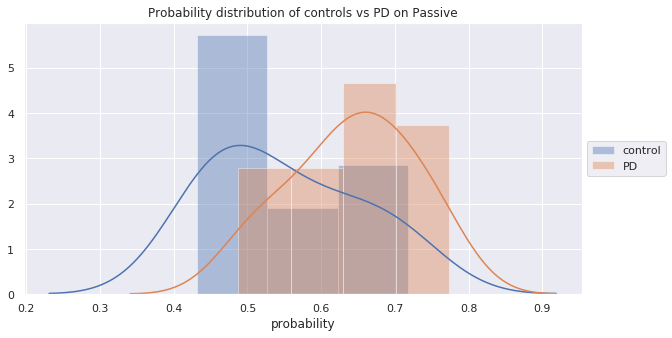

In [162]:
plt.figure(figsize = (10,5))
sns.distplot(data[data["class"] == "control"]["probability"], label = "control", )
sns.distplot(data[data["class"] == "PD"]["probability"], label = "PD")
plt.title("Probability distribution of controls vs PD on Passive")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Results:


The assessment above shows that the optimized model are able to score above >0.65 AUC-ROC, which means that our model is quite able to pick up some signals from our feature data. However, looking from the learning curves, despite our best effort in reducing variance between the training and cross-validation scores through feature reduction, it seems that it could only improve by a small margin. Most of the model score higher, or as much as the performance we had on mHealthTools (previous study on gait), with lower training time and smaller feature sets. 

<b> Logistic Regression </b> (so-far) might be a reasonable model in deployment due to its capability to generalize the features due to how the learning curve is able to least overfit due to the difference between the training scores and the validation scores getting closer to each other on each data iteration, which is only apparent in XGBoost. 

However, this is still an proof of concept of a predictive performance analysis where we would iterate the model further as we go with more data from the Gait database from the MPower.